# Linear Regression and Neural Network models
## Step by step plan:

Data ingestion<br>

Data wrangling and feature engineering
- Outlier removal<br>
- Tokenization and cleanup of job titles<br>
- Creation of dummies for all categorical variables<br>

*Train test split*<br>

Post split wrangling<br>
- Feature selection and database cleanup<br>
- Independent variable normalization<br>

### Model creation and evaluation
- Parameter evaluation<br>
- Actual vs predicted target variable analysis<br>
- Residuals analysis<br>

### Created models:
- One linear model<br>
- One linear model using exclusively significant independent variables<br>
- One neural network model<br>
- One linear model using PCA (some exploratory analysis is done for PCA results)<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from math import ceil, floor
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox, kstest, pearsonr
from scipy.special import inv_boxcox

In [2]:
sns.set() # makes all charts look better by default

## Data Ingestion

In [3]:
aijobs = pd.read_csv(r'https://ai-jobs.net/salaries/download/salaries.csv')
# Last accessed at 2024-03-23

In [4]:
aijobs # first look at the data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,Data Engineer,120000,CHF,136363,CH,50,CH,L
1,2024,SE,PT,Data Architect,212000,USD,212000,US,0,US,M
2,2024,SE,PT,Data Architect,93300,USD,93300,US,0,US,M
3,2024,MI,FT,Data Product Owner,321830,USD,321830,US,0,US,M
4,2024,MI,FT,Data Product Owner,124690,USD,124690,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
14796,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
14797,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
14798,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
14799,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [5]:
aijobs.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,14801.000000,14801,14801,14801,1.480100e+04,14801,14801.000000,14801,14801.000000,14801,14801
unique,NaN,4,4,152,NaN,23,NaN,88,NaN,77,3
top,NaN,SE,FT,Data Engineer,NaN,USD,NaN,US,NaN,US,M
freq,NaN,9673,14735,3158,NaN,13648,NaN,12896,NaN,12945,13638
mean,2023.136748,NaN,NaN,NaN,1.650843e+05,NaN,149895.249307,NaN,32.801838,NaN,NaN
std,0.700349,NaN,NaN,NaN,3.566669e+05,NaN,69037.515089,NaN,46.502476,NaN,NaN
min,2020.000000,NaN,NaN,NaN,1.400000e+04,NaN,15000.000000,NaN,0.000000,NaN,NaN
25%,2023.000000,NaN,NaN,NaN,1.021000e+05,NaN,102000.000000,NaN,0.000000,NaN,NaN
50%,2023.000000,NaN,NaN,NaN,1.422000e+05,NaN,141525.000000,NaN,0.000000,NaN,NaN
75%,2024.000000,NaN,NaN,NaN,1.875000e+05,NaN,185900.000000,NaN,100.000000,NaN,NaN


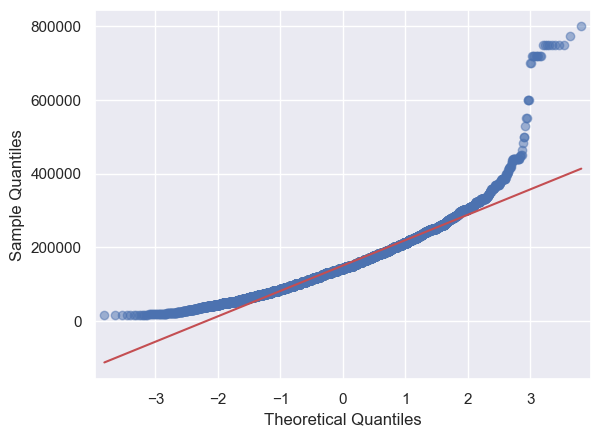

In [6]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

# Common data wrangling
These steps would be equally done for train and test bases with no population or sampled information, only individual ones, so no data leakage will occur if done now.

### Outlier removal

In [7]:
# The first outliers are extremely out of touch with the remainder of the database.
# They will skew the results too much and must be removed.
# According to Hair, from 2.5 to 4 standards deviations might be used to remove outliers.
# Visually, 4 deviations cover the worst cases.

mean = aijobs['salary_in_usd'].mean()
std = aijobs['salary_in_usd'].std()
outmax = mean + 2.5 * std
print(outmax)
outliers = aijobs[aijobs['salary_in_usd'] > outmax].index
print(outliers)
print(len(outliers))

aijobs.drop(outliers, inplace=True)
aijobs.reset_index(drop=True, inplace=True)
aijobs.sort_values('salary_in_usd', ascending=False).head()

322489.0370309836
Index([  153,   157,   213,   230,   237,   320,   370,   410,   428,   455,
       ...
       13453, 13632, 14474, 14526, 14531, 14583, 14728, 14747, 14793, 14796],
      dtype='int64', length=241)
241


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
3475,2024,SE,FT,Machine Learning Engineer,322000,USD,322000,US,100,US,M
3682,2024,SE,FT,Machine Learning Engineer,322000,USD,322000,US,100,US,M
513,2024,SE,FT,Data Scientist,322000,USD,322000,US,0,US,M
3,2024,MI,FT,Data Product Owner,321830,USD,321830,US,0,US,M
1879,2024,SE,FT,Research Scientist,321000,USD,321000,US,100,US,M


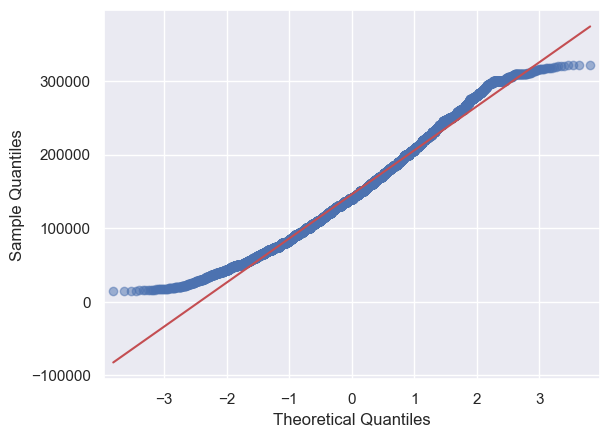

In [8]:
sm.qqplot(aijobs['salary_in_usd'], line='s', alpha=0.5)
plt.show()

In [9]:
aijobs.describe(include='all')

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
count,14560.000000,14560,14560,14560,1.456000e+04,14560,14560.000000,14560,14560.000000,14560,14560
unique,NaN,4,4,150,NaN,22,NaN,87,NaN,77,3
top,NaN,SE,FT,Data Engineer,NaN,USD,NaN,US,NaN,US,M
freq,NaN,9497,14496,3143,NaN,13416,NaN,12668,NaN,12716,13411
mean,2023.133036,NaN,NaN,NaN,1.611725e+05,NaN,145771.642239,NaN,33.063187,NaN,NaN
std,0.699676,NaN,NaN,NaN,3.578791e+05,NaN,59893.563509,NaN,46.598261,NaN,NaN
min,2020.000000,NaN,NaN,NaN,1.400000e+04,NaN,15000.000000,NaN,0.000000,NaN,NaN
25%,2023.000000,NaN,NaN,NaN,1.000000e+05,NaN,100000.000000,NaN,0.000000,NaN,NaN
50%,2023.000000,NaN,NaN,NaN,1.402500e+05,NaN,140000.000000,NaN,0.000000,NaN,NaN
75%,2024.000000,NaN,NaN,NaN,1.850000e+05,NaN,185000.000000,NaN,100.000000,NaN,NaN


## Feature Engineering

In [10]:
# There is no value in local currency salaries as they're not scaled.
# Salary in USD conveys the same useful information in a scaled manner.
aijobs.drop('salary', axis=1, inplace=True)

In [11]:
# An interesting variable to research
aijobs['work_abroad'] = aijobs['employee_residence'] != aijobs['company_location']
aijobs['work_abroad'] = aijobs['work_abroad'].astype(int)
aijobs.tail(10)

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,work_abroad
14550,2020,MI,FT,Data Engineer,USD,130800,ES,100,US,M,1
14551,2020,SE,FT,Machine Learning Engineer,EUR,45618,HR,100,HR,S,0
14552,2021,SE,FT,Director of Data Science,USD,168000,JP,0,JP,S,0
14553,2021,MI,FT,Data Scientist,SGD,119059,SG,100,IL,M,1
14554,2021,MI,FT,Data Engineer,EUR,28369,MT,50,MT,L,0
14555,2021,SE,FT,Data Specialist,USD,165000,US,100,US,L,0
14556,2021,MI,FT,Principal Data Scientist,USD,151000,US,100,US,L,0
14557,2020,EN,FT,Data Scientist,USD,105000,US,100,US,S,0
14558,2020,EN,CT,Business Data Analyst,USD,100000,US,100,US,L,0
14559,2021,SE,FT,Data Science Manager,INR,94665,IN,50,IN,L,0


In [12]:
# remote_ratio is categorical; the correct way to interpret those numbers is:
#   0 == On Site (less than 20% remote)
#  50 == Partially remote/hybird
# 100 == Fully remote (more than 80% remote)
# therefore using it as numerical would be creating a spurious relationship.
# It has to be dummified and will be switched for easier interpretation.

aijobs.loc[aijobs['remote_ratio'] == 0, 'remote_ratio'] = 'On_Site'
aijobs.loc[aijobs['remote_ratio'] == 50, 'remote_ratio'] = 'Hybrid'
aijobs.loc[aijobs['remote_ratio'] == 100, 'remote_ratio'] = 'Remote'

aijobs['remote_ratio']

0         Hybrid
1        On_Site
2        On_Site
3        On_Site
4        On_Site
          ...   
14555     Remote
14556     Remote
14557     Remote
14558     Remote
14559     Hybrid
Name: remote_ratio, Length: 14560, dtype: object

In [13]:
# Categorical columns will receive appropriate treatment
categorical_columns = ['employment_type', 'salary_currency', 'employee_residence', 'remote_ratio', 
                       'company_location', 'company_size']

In [14]:
# Quick look at job titles. This will receive a quick NLP method for processing.
print(len(aijobs['job_title'].unique()), "different job titles \n")
print(aijobs['job_title'].unique())

150 different job titles 

['Data Engineer' 'Data Architect' 'Data Product Owner' 'MLOps Engineer'
 'Data Specialist' 'Data Manager' 'Analytics Engineer' 'Data Analyst'
 'Machine Learning Scientist' 'Business Intelligence Engineer'
 'Data Scientist' 'Business Intelligence Analyst' 'Data Science'
 'Data Analytics Manager' 'Encounter Data Management Professional'
 'Machine Learning Engineer' 'Research Scientist' 'Research Engineer'
 'AI Engineer' 'Data Modeler' 'Research Analyst' 'ML Engineer'
 'Data Science Consultant' 'Applied Scientist' 'BI Analyst'
 'Data Integration Engineer' 'Data Integration Specialist'
 'Machine Learning Operations Engineer'
 'Machine Learning Infrastructure Engineer' 'Data Developer'
 'Business Intelligence' 'CRM Data Analyst' 'ETL Developer'
 'Business Intelligence Manager' 'Data Science Engineer' 'AI Architect'
 'Robotics Engineer' 'BI Developer' 'Head of Data' 'Data Science Manager'
 'Cloud Database Engineer' 'Data Operations Analyst'
 'Data Science Analyst' 

In [15]:
# Work on the terms contained in job titles.
terms = []
for title in aijobs['job_title'].unique():
    for word in title.split():
        terms.append(word)
terms = sorted(set(terms))
print(len(terms), "different terms in these titles \n")
print(terms)

80 different terms in these titles 

['&', 'AI', 'AWS', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Autonomous', 'Azure', 'BI', 'Big', 'Biologist', 'Business', 'CRM', 'Cloud', 'Compliance', 'Computational', 'Computer', 'Consultant', 'Data', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Director', 'ETL', 'Encounter', 'Engineer', 'Finance', 'Financial', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Intelligence', 'Lead', 'Learning', 'ML', 'MLOps', 'Machine', 'Management', 'Manager', 'Managing', 'Marketing', 'Modeler', 'Modeller', 'NLP', 'Operations', 'Ops', 'Owner', 'Pipeline', 'Power', 'Practitioner', 'Principal', 'Product', 'Professional', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Research', 'Researcher', 'Robotics', 'Sales', 'Science', 'Scientist', 'Software', 'Specialist', 'Staff', 'Strategist', 'Strategy', 'Technician', 'Vehicle', 'Vision', 'Visualization', 'of']


In [16]:
stop_words = ['&', 'of', 'Data', 'Learning', 'Computational', 'Computer', 'Autonomous', 'Technician', 'Professional']
# Justification: '&', 'of' and 'Data' are too generic for this project.
# 'Learning' has two contexts: Machine Learning and Deep Learning, yet both "Machine" and "Deep" are unique to them,
# so there's nothing to be gained from adding it.
# "Autonomous Vehicle Technician" is a job title whose words are all unique, so a single one is enough.
# "Computational Biologist" shares the same issue.
# "Encounter Data Management Professional" is the only to use "Encounter" and "Professional".
# "Computer Vision" is present in more than one job, but all of them use this same sequence, so it's the same situation.

In [17]:
synonym_terms = ['ML','Machine','MLOps', 'Operations','Business','BI','Intelligence','AWS','Cloud','Azure','Modeller',
                 'Modeler','Engineering','Engineer','Financial','Finance','Researcher','Research','Science','Scientist',
                 'Strategy','Strategist','Management','Manager', 'Managing']

In [18]:
# this uses the same pressupositions as above, but some words will mean the same thing.
synonyms = {'Machine': 'Machine|ML|MLOps',      # ML is short for Machine Learning
            'Operations':'MLOps|Operations',    # Ops is short for Operations
            'Intelligence':'Intelligence|BI',   # BI is short for Business Intelligence (Intelligence is exclusive to BI)
            'Business':'Business|BI',           # For consistency (Business is not exclusive to BI)
            'Cloud':'Cloud|AWS|Azure',          # There is a single instance for AWS and for Azure; both specific cloud tools
            'Modeler':'Modeler|Modeller',
            'Engineer':'Engineer|Engineering',
            'Finance':'Finance|Financial',
            'Research':'Research|Researcher',
            'Scientist':'Scientist|Science',
            'Strategist':'Strategist|Strategy',
            'Manager':'Management|Manager|Managing'}
# Note: Analyst and Analytics in this context will mean different things.

In [19]:
clean_terms = terms.copy()                                                   # copy method to keep the original list
[clean_terms.remove(term) for term in stop_words if term in clean_terms]     # remove stop words
[clean_terms.remove(term) for term in synonym_terms if term in clean_terms]  # synonyms will be processed differently
print(len(clean_terms), "terms after cleaning\n", len(synonyms), "synonyms\n ", len(clean_terms)+len(synonyms), "total terms\n")
print(clean_terms)

47 terms after cleaning
 12 synonyms
  59 total terms

['AI', 'Admin', 'Analyst', 'Analytics', 'Applied', 'Architect', 'Associate', 'Big', 'Biologist', 'CRM', 'Compliance', 'Consultant', 'Database', 'Decision', 'Deep', 'DevOps', 'Developer', 'Director', 'ETL', 'Encounter', 'Head', 'Infrastructure', 'Insight', 'Integration', 'Lead', 'Marketing', 'NLP', 'Ops', 'Owner', 'Pipeline', 'Power', 'Practitioner', 'Principal', 'Product', 'Programmer', 'Prompt', 'Quality', 'Quantitative', 'Reporting', 'Robotics', 'Sales', 'Software', 'Specialist', 'Staff', 'Vehicle', 'Vision', 'Visualization']


In [20]:
# dummization for all chosen job keywords
for job_string in clean_terms:
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(job_string, case=False).astype(int)
for job_string in synonyms.keys():
    aijobs['job_name_' + job_string] = aijobs['job_title'].str.contains(f'{synonyms[job_string]}', case=False).astype(int)
aijobs.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,job_name_Intelligence,job_name_Business,job_name_Cloud,job_name_Modeler,job_name_Engineer,job_name_Finance,job_name_Research,job_name_Scientist,job_name_Strategist,job_name_Manager
0,2024,MI,FT,Data Engineer,CHF,136363,CH,Hybrid,CH,L,...,0,0,0,0,1,0,0,0,0,0
1,2024,SE,PT,Data Architect,USD,212000,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
2,2024,SE,PT,Data Architect,USD,93300,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
3,2024,MI,FT,Data Product Owner,USD,321830,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0
4,2024,MI,FT,Data Product Owner,USD,124690,US,On_Site,US,M,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# dummization for all other categorical columns
df_dummies = pd.get_dummies(aijobs[categorical_columns], dtype=int)
aijobs = pd.concat([aijobs, df_dummies], axis=1)
aijobs.head()

,work_year,experience_level,employment_type,job_title,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,...,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_US,company_location_VN,company_location_ZA,company_size_L,company_size_M,company_size_S
0,2024,MI,FT,Data Engineer,CHF,136363,CH,Hybrid,CH,L,...,0,0,0,0,0,0,0,1,0,0
1,2024,SE,PT,Data Architect,USD,212000,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
2,2024,SE,PT,Data Architect,USD,93300,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
3,2024,MI,FT,Data Product Owner,USD,321830,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0
4,2024,MI,FT,Data Product Owner,USD,124690,US,On_Site,US,M,...,0,0,0,0,1,0,0,0,1,0


In [22]:
aijobs[categorical_columns].describe().loc['unique']

employment_type        4
salary_currency       22
employee_residence    87
remote_ratio           3
company_location      77
company_size           3
Name: unique, dtype: object

In [23]:
# To establish the features, categorical columns that are not dummies will need to be removed. Target variable too.

X_vars = aijobs.columns.tolist()
[X_vars.remove(col) for col in categorical_columns if col in X_vars]
X_vars.remove('job_title')
X_vars.remove('salary_in_usd')
X_vars.remove('experience_level')

In [24]:
# Comprehensive dummies will need one instance removed.
# They could be picked by hand, but the algorithm below selects the most popular for deletion.

c_dummies = aijobs[['employment_type_FL', 'employment_type_PT', 'employment_type_CT', 'employment_type_FT']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['remote_ratio_Remote', 'remote_ratio_Hybrid', 'remote_ratio_On_Site']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

c_dummies = aijobs[['company_size_S', 'company_size_M', 'company_size_L']].sum()
X_vars.remove(c_dummies[c_dummies == c_dummies.max()].index)

# These larger dummies will be implied in the intercept.
X_vars.remove('salary_currency_USD')
X_vars.remove('employee_residence_US')
X_vars.remove('company_location_US')

print(X_vars)

['work_year', 'work_abroad', 'job_name_AI', 'job_name_Admin', 'job_name_Analyst', 'job_name_Analytics', 'job_name_Applied', 'job_name_Architect', 'job_name_Associate', 'job_name_Big', 'job_name_Biologist', 'job_name_CRM', 'job_name_Compliance', 'job_name_Consultant', 'job_name_Database', 'job_name_Decision', 'job_name_Deep', 'job_name_DevOps', 'job_name_Developer', 'job_name_Director', 'job_name_ETL', 'job_name_Encounter', 'job_name_Head', 'job_name_Infrastructure', 'job_name_Insight', 'job_name_Integration', 'job_name_Lead', 'job_name_Marketing', 'job_name_NLP', 'job_name_Ops', 'job_name_Owner', 'job_name_Pipeline', 'job_name_Power', 'job_name_Practitioner', 'job_name_Principal', 'job_name_Product', 'job_name_Programmer', 'job_name_Prompt', 'job_name_Quality', 'job_name_Quantitative', 'job_name_Reporting', 'job_name_Robotics', 'job_name_Sales', 'job_name_Software', 'job_name_Specialist', 'job_name_Staff', 'job_name_Vehicle', 'job_name_Vision', 'job_name_Visualization', 'job_name_Machi

# Splitting and working the data before model fit

In [25]:
aijobs['experience_level'].unique()

array(['MI', 'SE', 'EN', 'EX'], dtype=object)

In [26]:
X_train = {}
X_test = {}
y_train = {}
y_test = {}
lmbda = 0.4725 #selected from the best performing model previously

for exp in aijobs['experience_level'].unique():
    X_train[exp], X_test[exp], y_train[exp], y_test[exp] = train_test_split(aijobs[aijobs['experience_level'] == exp][X_vars], 
                                                                            aijobs[aijobs['experience_level'] == exp]['salary_in_usd'], 
                                                                            test_size=0.25, random_state=42)
    y_vals = boxcox(y_train[exp], lmbda)
    y_train[exp] = pd.Series(y_vals, index=y_train[exp].index, name='transformed_salary')
    y_vals = boxcox(y_test[exp], lmbda)
    y_test[exp] = pd.Series(y_vals, index=y_test[exp].index, name='transformed_salary')

In [27]:
X_train['MI']

,work_year,work_abroad,job_name_AI,job_name_Admin,job_name_Analyst,job_name_Analytics,job_name_Applied,job_name_Architect,job_name_Associate,job_name_Big,...,company_location_SE,company_location_SG,company_location_SI,company_location_TH,company_location_TR,company_location_UA,company_location_VN,company_location_ZA,company_size_L,company_size_S
5274,2023,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1283,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
403,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14257,2022,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
9868,2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3505,2024,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3647,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4132,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2849,2024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# To delete columns with too few instances in order to avoid overfitting
# Hair says 5 entries is a minimum threshold; any dummy with less than 5 examples is too prone to overfitting.

def del_vars(X_train, X_test, y_train, y_test, printing=False):
    """
    This function deletes all columns in training base that have too few instances and will result in overfitting
    It also deletes every row that had an instance in such columns in order to prevent assumptions implied in the intecept
    As these variables are rendered unworkable, they are also deleted from test base (no information leak happens)
    Every row removed from independent variables bases (X) is also removed from the dependent variable array (y).
    """
    
    if printing == True:
        print("Before:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    deletions = 1 #just to enter the loop
    train_dropped = []
    while deletions > 0:
        deletions = X_train.shape[0] # store the dataframe size for later comparison
        X_sum = X_train.sum()
        exclusion_list = X_sum[X_sum < 5].index # create the exclusion column list

        # deleting all rows with any positive value in those variables
        X_delete = X_train[exclusion_list].sum(axis=1)
        rows_to_delete = X_delete[X_delete != 0]
        X_train.drop(rows_to_delete.index, inplace=True)
        
        [train_dropped.append(item) for item in rows_to_delete.index] # list all deleted rows for later consistency wity y array
        deletions = deletions - X_train.shape[0] # difference from previous dataframe size
        if printing == True:
            print('Rows deleted:', deletions) # deleted rows in this loop
            print('Columns dropped:', len(exclusion_list)) # cumulative columns to be deleted
        # loop until there are no more deleted rows
        
    X_train.drop(exclusion_list, axis=1, inplace=True) # dropping columns from train base now
    
    test_deletion = X_test[exclusion_list].sum(axis=1) # filter a dataframe by select all exclusion rows and their sum
    test_dropped = test_deletion[test_deletion > 0].index # finding all rows with a positive value on any of those dummies
    X_test.drop(test_dropped, inplace=True) # dropping unworkable test rows
    X_test.drop(exclusion_list, axis=1, inplace=True) # dropping columns from test base
    
    # shaping dependent variable arrays to match independent variables dataframes
    y_train.drop(train_dropped, inplace=True)
    y_test.drop(test_dropped, inplace=True)
    if printing == True:
        print("After:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [29]:
for exp in aijobs['experience_level'].unique():
    print(exp)
    del_vars(X_train[exp], X_test[exp], y_train[exp], y_test[exp], printing=True)
    print('\n')

MI
Before: (2627, 251) (2627,) (876, 251) (876,)
Rows deleted: 130
Columns dropped: 176
Rows deleted: 13
Columns dropped: 185
Rows deleted: 0
Columns dropped: 185
After: (2484, 66) (2484,) (825, 66) (825,)


SE
Before: (7122, 251) (7122,) (2375, 251) (2375,)
Rows deleted: 81
Columns dropped: 166
Rows deleted: 3
Columns dropped: 168
Rows deleted: 0
Columns dropped: 168
After: (7038, 83) (7038,) (2333, 83) (2333,)


EN
Before: (858, 251) (858,) (286, 251) (286,)
Rows deleted: 99
Columns dropped: 204
Rows deleted: 17
Columns dropped: 211
Rows deleted: 0
Columns dropped: 211
After: (742, 40) (742,) (243, 40) (243,)


EX
Before: (312, 251) (312,) (104, 251) (104,)
Rows deleted: 23
Columns dropped: 228
Rows deleted: 3
Columns dropped: 231
Rows deleted: 0
Columns dropped: 231
After: (286, 20) (286,) (87, 20) (87,)




In [30]:
for exp in aijobs['experience_level'].unique():
    X_train[exp] = sm.add_constant(X_train[exp])
    X_test[exp] = sm.add_constant(X_test[exp])

# Starting the Model

In [31]:
# Create a model

def model_creation(X_train, X_test, y_train, y_test, cov_type):
    # A few variables look like they still have high p-values even in an isolated model.
    # Loop until only significant variables are present
    NOT_significant_vars = [1] # creation of a non empty list to enter the loop
    while NOT_significant_vars != []:
        # The model is created, but a new one using only the previously resulting significant variables 
        # did not render a new model that had all variables resulting significant.
        # A stepwise deletion for these variables will be done here until that happens.
        OLS_model = sm.OLS(y_train, X_train).fit(cov_type=cov_type)

        # Bring all not significant variables into a single list
        NOT_significant_vars = OLS_model.pvalues[OLS_model.pvalues > 0.05]
        NOT_significant_vars = list(NOT_significant_vars.index)

        # remove the intercept from this list so it isn't removed from the model
        if 'const' in NOT_significant_vars:
            NOT_significant_vars.remove('const')

        X_train.drop(NOT_significant_vars, axis=1, inplace=True)
        X_test.drop(NOT_significant_vars, axis=1, inplace=True)
        del_vars(X_train, X_test, y_train, y_test, printing=True)
    
    return OLS_model

In [32]:
# Design a function to create a lot of plots
def create_scatter(y_pred, y_test):

    comparison_df = pd.DataFrame((y_test, y_pred, y_test - y_pred)).transpose()
    comparison_df.columns = ["Observed", "Predicted", "Residual"]
    display(comparison_df.describe())

    m, b = np.polyfit(y_test, y_pred, deg=1)
    R_2 = pearsonr(y_test, y_pred)
    
    # Adjusting charts' limits (with a buffer)
    llim = min(y_test.min(), y_pred.min()) - 30
    ulim = max(y_test.max(), y_pred.max()) + 30
    llim = floor(llim/100)*100
    ulim = ceil(ulim/100)*100

    print('Scatter plot of Predicted vs Actual values')

    g = sns.jointplot(x=y_test, y=y_pred, kind="reg", height=6.7, xlim=(llim, ulim), ylim=(llim, ulim), 
                      joint_kws={'scatter_kws':dict(alpha=0.2)}, line_kws=dict(color="r"))

    for i in [400, 700]:
        g.refline(x=i, y=i, linestyle=":", alpha=.5)

    plt.xlabel('Observed y values')
    plt.ylabel('Predicted y values')

    plt.show()

    print(f'Prediction R squared: {R_2[0]**2:.4f} p-value: {R_2[1]:.4f}')
    print(f'y = {m:.4f}x {b:+.1f} \n\n')
    
    
    print('RESIDUALS PLOT - SORTED BY ASCENDING OBSERVED DEPENDENT VARIABLE')

    residuals = comparison_df.sort_values('Observed')['Residual']
    
    fig = plt.figure(figsize=(6.3, 3.5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(residuals.values, linewidth=0.1)
    plt.show()
    
    # tests and histogram to look at residuals' normality
    print('RESIDUALS NORMALITY')
    print(kstest(residuals, "norm"))
    print('Residuals Histogram')
    plt.hist(residuals, bins=20)
    plt.show()

nonrobust 

MI 


Before: (2484, 22) (2484,) (825, 22) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 22) (2484,) (825, 22) (825,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     53.12
Date:                Thu, 11 Apr 2024   Prob (F-statistic):          1.80e-160
Time:                        14:28:44   Log-Likelihood:                -14699.
No. Observations:                2484   AIC:                         2.944e+04
Df Residuals:                    2465   BIC:                         2.955e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   489.3096      3.805    128.584      0.000     481.848     496.772
job_name_Applied         75.1104     11.854      6.336      0.000      51.866      98.355
job_name_Architect       81.9731     22.852      3.587      0.000      37.161     126.785
job_name_Consultant     -53.9694     25.231     -2.139      0.033    -103.445      -4.493
job_name_Product         87.0325     24.724      3.520      0.000      38.551     135.514
job_name_Machine         56.6344      6.761      8.376      0.000      43.376      69.893
job_name_Operations     -44.7755     20.459     -2.189      0.029     -84.895      -4.656
job_name_Modeler         66.3104     28.810      2.302      0.021       9.815     122.806
job_name_Engineer        54.3332      4.745     11.451      0.000      45.029      63.638
job_name_Research        37.7964      7.836      4.823      0.000      22.430      53.163
job_name_Scientist       63.0943      4.922     12.819      0.000      53.443      72.746
job_name_Manager         31.9511      8.428      3.791      0.000      15.423      48.479
salary_currency_CAD    -103.5960     32.154     -3.222      0.001    -166.648     -40.544
salary_currency_GBP    -117.6811      6.491    -18.130      0.000    -130.409    -104.953
employee_residence_BR   -59.4242     17.155     -3.464      0.001     -93.064     -25.785
employee_residence_GR   -84.0428     17.131     -4.906      0.000    -117.635     -50.450
employee_residence_LV   -85.0410     20.240     -4.202      0.000    -124.730     -45.351
remote_ratio_Remote     -17.9142      4.137     -4.330      0.000     -26.026      -9.802
company_location_BR     -59.4242     17.155     -3.464      0.001     -93.064     -25.785
company_location_GR     -84.0428     17.131     -4.906      0.000    -117.635     -50.450
company_location_IN    -288.0768     28.643    -10.058      0.000    -344.243    -231.911
company_location_LV     -85.0410     20.240     -4.202      0.000    -124.730     -45.351
==============================================================================
Omnibus:                        7.360   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.388
Skew:                           0.134   Prob(JB):                       0.0249
Kurtosis:                       2.991   Cond. No.                     4.57e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.64e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

___________________________________________________________


nonrobust 

SE 


Before: (7038, 24) (7038,) (2333, 24) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 24) (7038,) (2333, 24) (2333,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     135.1
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:28:44   Log-Likelihood:                -41327.
No. Observations:                7038   AIC:                         8.270e+04
Df Residuals:                    7016   BIC:                         8.285e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.339e+04   3463.565     -3.866      0.000   -2.02e+04   -6600.547
work_year                 6.8808      1.712      4.019      0.000       3.525      10.237
job_name_AI              29.5529     10.313      2.866      0.004       9.337      49.769
job_name_Applied         37.5683      6.111      6.147      0.000      25.589      49.548
job_name_Architect       81.2863      5.879     13.826      0.000      69.761      92.811
job_name_Consultant     -93.0536     13.120     -7.093      0.000    -118.773     -67.334
job_name_Lead            28.9266     13.653      2.119      0.034       2.162      55.692
job_name_Principal      109.6735     30.991      3.539      0.000      48.921     170.426
job_name_Vision          78.4071     19.933      3.934      0.000      39.332     117.482
job_name_Machine         56.1605      3.155     17.798      0.000      49.975      62.346
job_name_Engineer        65.6046      3.027     21.670      0.000      59.670      71.539
job_name_Research        36.4697      4.691      7.775      0.000      27.274      45.665
job_name_Scientist       84.7752      3.070     27.617      0.000      78.758      90.793
job_name_Manager         44.0045      6.891      6.385      0.000      30.495      57.514
salary_currency_CAD     -83.5117     21.570     -3.872      0.000    -125.796     -41.228
salary_currency_EUR    -172.2497     11.781    -14.621      0.000    -195.344    -149.156
salary_currency_GBP    -142.5242      8.044    -17.718      0.000    -158.293    -126.755
salary_currency_INR    -286.2716     27.665    -10.348      0.000    -340.504    -232.039
employee_residence_CO   -91.5565     17.580     -5.208      0.000    -126.019     -57.094
employee_residence_ZA   -47.5475     17.913     -2.654      0.008     -82.663     -12.432
company_location_BR    -276.2975     38.701     -7.139      0.000    -352.164    -200.431
company_location_CO     -91.5565     17.580     -5.208      0.000    -126.019     -57.094
company_location_ES     -83.8486     15.873     -5.282      0.000    -114.965     -52.732
company_location_ZA     -47.5475     17.913     -2.654      0.008     -82.663     -12.432
==============================================================================
Omnibus:                        8.087   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.517
Skew:                           0.045   Prob(JB):                       0.0233
Kurtosis:                       2.868   Cond. No.                     7.84e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.69e-32. This might indicate that there are
str

___________________________________________________________


nonrobust 

EN 


Before: (742, 8) (742,) (243, 8) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 8) (742,) (243, 8) (243,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     43.11
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           4.74e-51
Time:                        14:28:44   Log-Likelihood:                -4403.0
No. Observations:                 742   AIC:                             8822.
Df Residuals:                     734   BIC:                             8859.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 477.5119      4.639    102.925      0.000     468.404     486.620
job_name_Applied      115.0530     28.080      4.097      0.000      59.926     170.180
job_name_Machine       43.0204     14.501      2.967      0.003      14.551      71.489
job_name_Research      71.0071     10.440      6.801      0.000      50.511      91.503
employment_type_PT    -96.1629     29.660     -3.242      0.001    -154.392     -37.933
salary_currency_EUR  -144.6179     15.770     -9.170      0.000    -175.577    -113.658
salary_currency_GBP  -132.1629     12.887    -10.255      0.000    -157.463    -106.863
remote_ratio_Remote   -34.8224      7.583     -4.592      0.000     -49.709     -19.936
==============================================================================
Omnibus:                       14.305   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.034
Skew:                           0.188   Prob(JB):                     4.46e-05
Kurtosis:                       3.712   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

___________________________________________________________


nonrobust 

EX 


Before: (286, 3) (286,) (87, 3) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 3) (286,) (87, 3) (87,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     7.074
Date:                Thu, 11 Apr 2024   Prob (F-statistic):            0.00100
Time:                        14:28:44   Log-Likelihood:                -1725.4
No. Observations:                 286   AIC:                             3457.
Df Residuals:                     283   BIC:                             3468.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 627.8954      7.724     81.288      0.000     612.691     643.100
job_name_Director      52.3093     22.066      2.371      0.018       8.875      95.744
remote_ratio_Remote    35.0994     12.424      2.825      0.005      10.643      59.556
==============================================================================
Omnibus:                        8.953   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.591
Skew:                          -0.319   Prob(JB):                       0.0225
Kurtosis:                       2.520   Cond. No.                         4.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

___________________________________________________________




,Observed,Predicted,Residual
count,3488.000000,3488.000000,3488.000000
mean,576.100189,572.089291,4.010898
std,113.938141,71.326194,88.858955
min,205.530046,183.318617,-301.051646
25%,497.601961,529.747495,-57.703040
50%,579.108975,595.352057,2.975939
75%,653.339300,617.914658,64.096782
max,841.488869,761.186051,278.214646


Scatter plot of Predicted vs Actual values


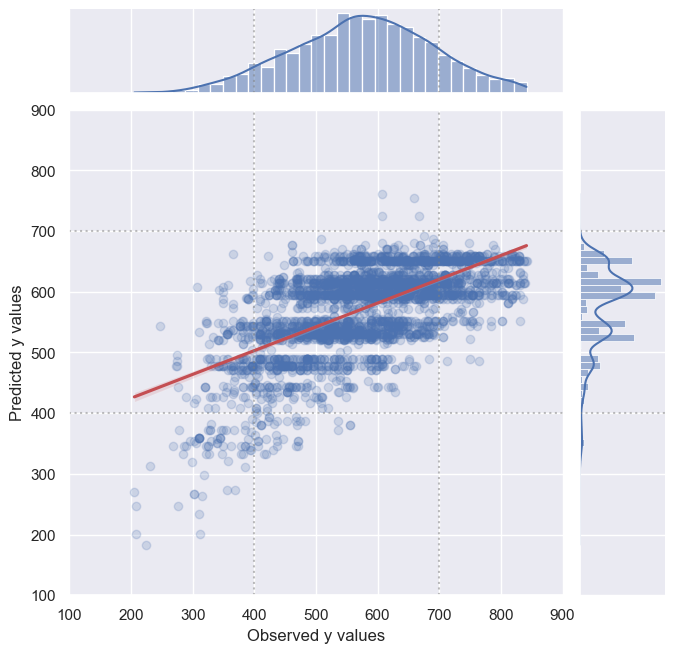

Prediction R squared: 0.3918 p-value: 0.0000
y = 0.3918x +346.4 


RESIDUALS PLOT - SORTED BY ASCENDING OBSERVED DEPENDENT VARIABLE


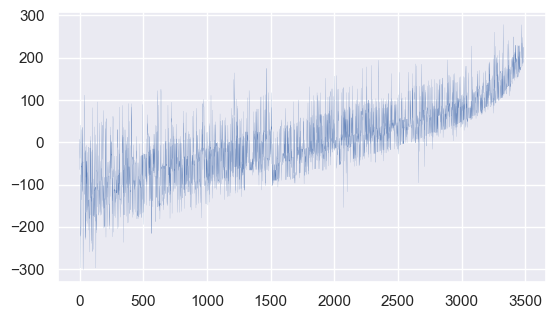

RESIDUALS NORMALITY
KstestResult(statistic=0.49868647055973103, pvalue=0.0, statistic_location=3.0083089879029785, statistic_sign=-1)
Residuals Histogram


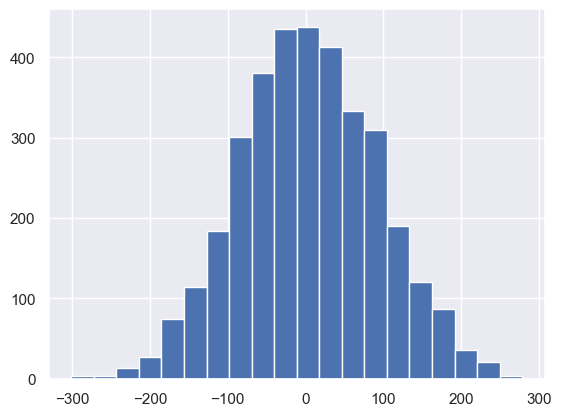

____________________________________________________________________________________ 
___________________________________________________________________________________





HC0 

MI 


Before: (2484, 22) (2484,) (825, 22) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 22) (2484,) (825, 22) (825,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 18
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     88.34
Date:                Thu, 11 Apr 2024   Prob (F-statistic):          2.74e-250
Time:                        14:28:46   Log-Likelihood:                -14699.
No. Observations:                2484   AIC:                         2.944e+04
Df Residuals:                    2465   BIC:                         2.955e+04
Df Model:                          18                                         
Covariance Type:                  HC0                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   489.3096      3.427    142.789      0.000     482.593     496.026
job_name_Applied         75.1104     11.473      6.547      0.000      52.624      97.596
job_name_Architect       81.9731     17.513      4.681      0.000      47.649     116.297
job_name_Consultant     -53.9694     16.552     -3.261      0.001     -86.410     -21.529
job_name_Product         87.0325     24.384      3.569      0.000      39.240     134.825
job_name_Machine         56.6344      7.276      7.784      0.000      42.374      70.895
job_name_Operations     -44.7755     18.681     -2.397      0.017     -81.389      -8.162
job_name_Modeler         66.3104     27.410      2.419      0.016      12.588     120.033
job_name_Engineer        54.3332      4.499     12.076      0.000      45.515      63.152
job_name_Research        37.7964      9.878      3.826      0.000      18.436      57.157
job_name_Scientist       63.0943      4.866     12.967      0.000      53.558      72.631
job_name_Manager         31.9511      7.979      4.004      0.000      16.312      47.591
salary_currency_CAD    -103.5960     33.411     -3.101      0.002    -169.080     -38.112
salary_currency_GBP    -117.6811      5.211    -22.581      0.000    -127.895    -107.467
employee_residence_BR   -59.4242     10.242     -5.802      0.000     -79.498     -39.350
employee_residence_GR   -84.0428     12.723     -6.606      0.000    -108.978     -59.107
employee_residence_LV   -85.0410     12.804     -6.642      0.000    -110.136     -59.946
remote_ratio_Remote     -17.9142      4.045     -4.428      0.000     -25.843      -9.986
company_location_BR     -59.4242     10.242     -5.802      0.000     -79.498     -39.350
company_location_GR     -84.0428     12.723     -6.606      0.000    -108.978     -59.107
company_location_IN    -288.0768     13.059    -22.059      0.000    -313.672    -262.481
company_location_LV     -85.0410     12.804     -6.642      0.000    -110.136     -59.946
==============================================================================
Omnibus:                        7.360   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.388
Skew:                           0.134   Prob(JB):                       0.0249
Kurtosis:                       2.991   Cond. No.                     4.57e+17
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The smallest eigenvalue is 1.64e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

___________________________________________________________


HC0 

SE 


Before: (7038, 24) (7038,) (2333, 24) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 24) (7038,) (2333, 24) (2333,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 21
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     208.3
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:28:46   Log-Likelihood:                -41327.
No. Observations:                7038   AIC:                         8.270e+04
Df Residuals:                    7016   BIC:                         8.285e+04
Df Model:                          21                                         
Covariance Type:                  HC0                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.339e+04   3427.199     -3.907      0.000   -2.01e+04   -6672.993
work_year                 6.8808      1.694      4.062      0.000       3.561      10.201
job_name_AI              29.5529     12.035      2.455      0.014       5.964      53.142
job_name_Applied         37.5683      5.840      6.433      0.000      26.123      49.014
job_name_Architect       81.2863      6.103     13.318      0.000      69.324      93.249
job_name_Consultant     -93.0536      7.583    -12.272      0.000    -107.915     -78.192
job_name_Lead            28.9266     14.077      2.055      0.040       1.337      56.516
job_name_Principal      109.6735     20.883      5.252      0.000      68.743     150.604
job_name_Vision          78.4071     15.015      5.222      0.000      48.978     107.836
job_name_Machine         56.1605      3.210     17.493      0.000      49.868      62.453
job_name_Engineer        65.6046      3.016     21.755      0.000      59.694      71.515
job_name_Research        36.4697      5.090      7.165      0.000      26.494      46.446
job_name_Scientist       84.7752      2.979     28.457      0.000      78.936      90.614
job_name_Manager         44.0045      6.870      6.405      0.000      30.539      57.470
salary_currency_CAD     -83.5117     15.718     -5.313      0.000    -114.319     -52.704
salary_currency_EUR    -172.2497     11.501    -14.978      0.000    -194.790    -149.709
salary_currency_GBP    -142.5242      6.745    -21.129      0.000    -155.745    -129.304
salary_currency_INR    -286.2716     22.227    -12.879      0.000    -329.836    -242.707
employee_residence_CO   -91.5565     11.197     -8.177      0.000    -113.502     -69.611
employee_residence_ZA   -47.5475     11.945     -3.980      0.000     -70.960     -24.135
company_location_BR    -276.2975     35.413     -7.802      0.000    -345.706    -206.889
company_location_CO     -91.5565     11.197     -8.177      0.000    -113.502     -69.611
company_location_ES     -83.8486     13.609     -6.161      0.000    -110.522     -57.176
company_location_ZA     -47.5475     11.945     -3.980      0.000     -70.960     -24.135
==============================================================================
Omnibus:                        8.087   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.517
Skew:                           0.045   Prob(JB):                       0.0233
Kurtosis:                       2.868   Cond. No.                     7.84e+20
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The smallest eigenvalue is 4.69e-32. This might indicate that there are
strong multicollinearity problems or th

___________________________________________________________


HC0 

EN 


Before: (742, 8) (742,) (243, 8) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 8) (742,) (243, 8) (243,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     67.34
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           6.52e-75
Time:                        14:28:46   Log-Likelihood:                -4403.0
No. Observations:                 742   AIC:                             8822.
Df Residuals:                     734   BIC:                             8859.
Df Model:                           7                                         
Covariance Type:                  HC0                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 477.5119      4.568    104.544      0.000     468.560     486.464
job_name_Applied      115.0530     36.056      3.191      0.001      44.385     185.721
job_name_Machine       43.0204     19.173      2.244      0.025       5.443      80.598
job_name_Research      71.0071     14.221      4.993      0.000      43.134      98.880
employment_type_PT    -96.1629     17.874     -5.380      0.000    -131.195     -61.131
salary_currency_EUR  -144.6179     10.862    -13.314      0.000    -165.907    -123.329
salary_currency_GBP  -132.1629      8.726    -15.147      0.000    -149.265    -115.061
remote_ratio_Remote   -34.8224      7.361     -4.730      0.000     -49.251     -20.394
==============================================================================
Omnibus:                       14.305   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.034
Skew:                           0.188   Prob(JB):                     4.46e-05
Kurtosis:                       3.712   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

___________________________________________________________


HC0 

EX 


Before: (286, 3) (286,) (87, 3) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 3) (286,) (87, 3) (87,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     10.30
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           4.80e-05
Time:                        14:28:46   Log-Likelihood:                -1725.4
No. Observations:                 286   AIC:                             3457.
Df Residuals:                     283   BIC:                             3468.
Df Model:                           2                                         
Covariance Type:                  HC0                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 627.8954      7.579     82.849      0.000     613.041     642.750
job_name_Director      52.3093     14.612      3.580      0.000      23.670      80.948
remote_ratio_Remote    35.0994     12.640      2.777      0.005      10.326      59.872
==============================================================================
Omnibus:                        8.953   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.591
Skew:                          -0.319   Prob(JB):                       0.0225
Kurtosis:                       2.520   Cond. No.                         4.01
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

___________________________________________________________




,Observed,Predicted,Residual
count,3488.000000,3488.000000,3488.000000
mean,576.100189,572.089291,4.010898
std,113.938141,71.326194,88.858955
min,205.530046,183.318617,-301.051646
25%,497.601961,529.747495,-57.703040
50%,579.108975,595.352057,2.975939
75%,653.339300,617.914658,64.096782
max,841.488869,761.186051,278.214646


Scatter plot of Predicted vs Actual values


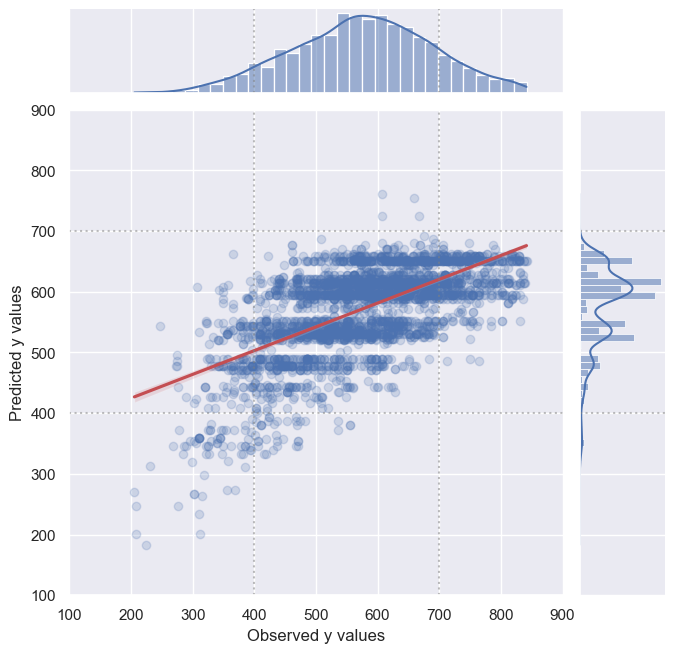

Prediction R squared: 0.3918 p-value: 0.0000
y = 0.3918x +346.4 


RESIDUALS PLOT - SORTED BY ASCENDING OBSERVED DEPENDENT VARIABLE


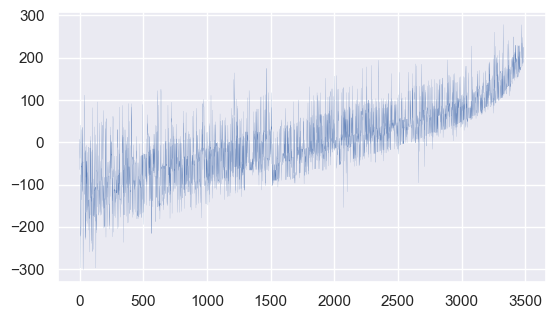

RESIDUALS NORMALITY
KstestResult(statistic=0.49868647055973103, pvalue=0.0, statistic_location=3.0083089879029785, statistic_sign=-1)
Residuals Histogram


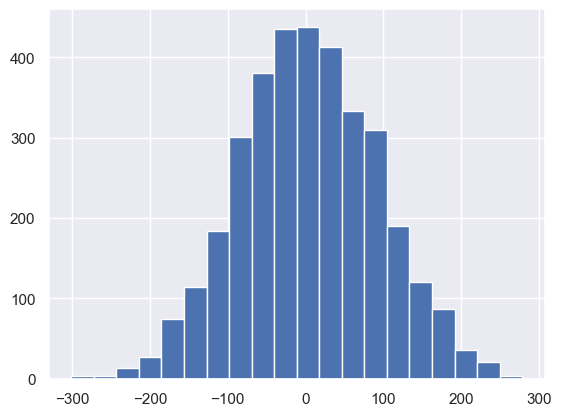

____________________________________________________________________________________ 
___________________________________________________________________________________





HC1 

MI 


Before: (2484, 22) (2484,) (825, 22) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 22) (2484,) (825, 22) (825,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 18
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     87.66
Date:                Thu, 11 Apr 2024   Prob (F-statistic):          1.07e-248
Time:                        14:28:48   Log-Likelihood:                -14699.
No. Observations:                2484   AIC:                         2.944e+04
Df Residuals:                    2465   BIC:                         2.955e+04
Df Model:                          18                                         
Covariance Type:                  HC1                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   489.3096      3.440    142.242      0.000     482.567     496.052
job_name_Applied         75.1104     11.517      6.522      0.000      52.538      97.683
job_name_Architect       81.9731     17.580      4.663      0.000      47.517     116.429
job_name_Consultant     -53.9694     16.615     -3.248      0.001     -86.535     -21.404
job_name_Product         87.0325     24.478      3.556      0.000      39.056     135.008
job_name_Machine         56.6344      7.304      7.754      0.000      42.319      70.950
job_name_Operations     -44.7755     18.753     -2.388      0.017     -81.530      -8.021
job_name_Modeler         66.3104     27.515      2.410      0.016      12.381     120.239
job_name_Engineer        54.3332      4.517     12.029      0.000      45.481      63.186
job_name_Research        37.7964      9.916      3.812      0.000      18.362      57.231
job_name_Scientist       63.0943      4.884     12.918      0.000      53.521      72.667
job_name_Manager         31.9511      8.010      3.989      0.000      16.251      47.651
salary_currency_CAD    -103.5960     33.539     -3.089      0.002    -169.332     -37.860
salary_currency_GBP    -117.6811      5.231    -22.495      0.000    -127.935    -107.428
employee_residence_BR   -59.4242     10.281     -5.780      0.000     -79.575     -39.273
employee_residence_GR   -84.0428     12.771     -6.581      0.000    -109.074     -59.011
employee_residence_LV   -85.0410     12.853     -6.616      0.000    -110.232     -59.850
remote_ratio_Remote     -17.9142      4.061     -4.411      0.000     -25.873      -9.955
company_location_BR     -59.4242     10.281     -5.780      0.000     -79.575     -39.273
company_location_GR     -84.0428     12.771     -6.581      0.000    -109.074     -59.011
company_location_IN    -288.0768     13.109    -21.975      0.000    -313.771    -262.383
company_location_LV     -85.0410     12.853     -6.616      0.000    -110.232     -59.850
==============================================================================
Omnibus:                        7.360   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.388
Skew:                           0.134   Prob(JB):                       0.0249
Kurtosis:                       2.991   Cond. No.                     4.57e+17
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 1.64e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

___________________________________________________________


HC1 

SE 


Before: (7038, 24) (7038,) (2333, 24) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 24) (7038,) (2333, 24) (2333,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 21
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     207.7
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:28:48   Log-Likelihood:                -41327.
No. Observations:                7038   AIC:                         8.270e+04
Df Residuals:                    7016   BIC:                         8.285e+04
Df Model:                          21                                         
Covariance Type:                  HC1                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.339e+04   3432.568     -3.901      0.000   -2.01e+04   -6662.470
work_year                 6.8808      1.697      4.055      0.000       3.555      10.206
job_name_AI              29.5529     12.054      2.452      0.014       5.927      53.179
job_name_Applied         37.5683      5.849      6.423      0.000      26.105      49.032
job_name_Architect       81.2863      6.113     13.298      0.000      69.305      93.267
job_name_Consultant     -93.0536      7.595    -12.253      0.000    -107.939     -78.169
job_name_Lead            28.9266     14.099      2.052      0.040       1.294      56.559
job_name_Principal      109.6735     20.916      5.244      0.000      68.679     150.668
job_name_Vision          78.4071     15.039      5.214      0.000      48.932     107.882
job_name_Machine         56.1605      3.215     17.466      0.000      49.858      62.463
job_name_Engineer        65.6046      3.020     21.721      0.000      59.685      71.524
job_name_Research        36.4697      5.098      7.154      0.000      26.478      46.461
job_name_Scientist       84.7752      2.984     28.412      0.000      78.927      90.623
job_name_Manager         44.0045      6.881      6.395      0.000      30.518      57.491
salary_currency_CAD     -83.5117     15.743     -5.305      0.000    -114.367     -52.656
salary_currency_EUR    -172.2497     11.519    -14.954      0.000    -194.826    -149.674
salary_currency_GBP    -142.5242      6.756    -21.096      0.000    -155.765    -129.283
salary_currency_INR    -286.2716     22.262    -12.859      0.000    -329.905    -242.639
employee_residence_CO   -91.5565     11.214     -8.164      0.000    -113.536     -69.577
employee_residence_ZA   -47.5475     11.964     -3.974      0.000     -70.997     -24.098
company_location_BR    -276.2975     35.469     -7.790      0.000    -345.815    -206.780
company_location_CO     -91.5565     11.214     -8.164      0.000    -113.536     -69.577
company_location_ES     -83.8486     13.630     -6.152      0.000    -110.563     -57.134
company_location_ZA     -47.5475     11.964     -3.974      0.000     -70.997     -24.098
==============================================================================
Omnibus:                        8.087   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.517
Skew:                           0.045   Prob(JB):                       0.0233
Kurtosis:                       2.868   Cond. No.                     7.84e+20
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 4.69e-32. This might indicate that there are
strong multicollinearity problems or th

___________________________________________________________


HC1 

EN 


Before: (742, 8) (742,) (243, 8) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 8) (742,) (243, 8) (243,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     66.62
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           3.03e-74
Time:                        14:28:48   Log-Likelihood:                -4403.0
No. Observations:                 742   AIC:                             8822.
Df Residuals:                     734   BIC:                             8859.
Df Model:                           7                                         
Covariance Type:                  HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 477.5119      4.592    103.978      0.000     468.511     486.513
job_name_Applied      115.0530     36.252      3.174      0.002      44.001     186.105
job_name_Machine       43.0204     19.277      2.232      0.026       5.239      80.802
job_name_Research      71.0071     14.299      4.966      0.000      42.982      99.032
employment_type_PT    -96.1629     17.971     -5.351      0.000    -131.385     -60.941
salary_currency_EUR  -144.6179     10.921    -13.242      0.000    -166.022    -123.213
salary_currency_GBP  -132.1629      8.773    -15.065      0.000    -149.358    -114.968
remote_ratio_Remote   -34.8224      7.401     -4.705      0.000     -49.329     -20.316
==============================================================================
Omnibus:                       14.305   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.034
Skew:                           0.188   Prob(JB):                     4.46e-05
Kurtosis:                       3.712   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

___________________________________________________________


HC1 

EX 


Before: (286, 3) (286,) (87, 3) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 3) (286,) (87, 3) (87,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     10.19
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           5.31e-05
Time:                        14:28:48   Log-Likelihood:                -1725.4
No. Observations:                 286   AIC:                             3457.
Df Residuals:                     283   BIC:                             3468.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 627.8954      7.619     82.414      0.000     612.963     642.828
job_name_Director      52.3093     14.689      3.561      0.000      23.519      81.100
remote_ratio_Remote    35.0994     12.706      2.762      0.006      10.195      60.003
==============================================================================
Omnibus:                        8.953   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.591
Skew:                          -0.319   Prob(JB):                       0.0225
Kurtosis:                       2.520   Cond. No.                         4.01
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

___________________________________________________________




,Observed,Predicted,Residual
count,3488.000000,3488.000000,3488.000000
mean,576.100189,572.089291,4.010898
std,113.938141,71.326194,88.858955
min,205.530046,183.318617,-301.051646
25%,497.601961,529.747495,-57.703040
50%,579.108975,595.352057,2.975939
75%,653.339300,617.914658,64.096782
max,841.488869,761.186051,278.214646


Scatter plot of Predicted vs Actual values


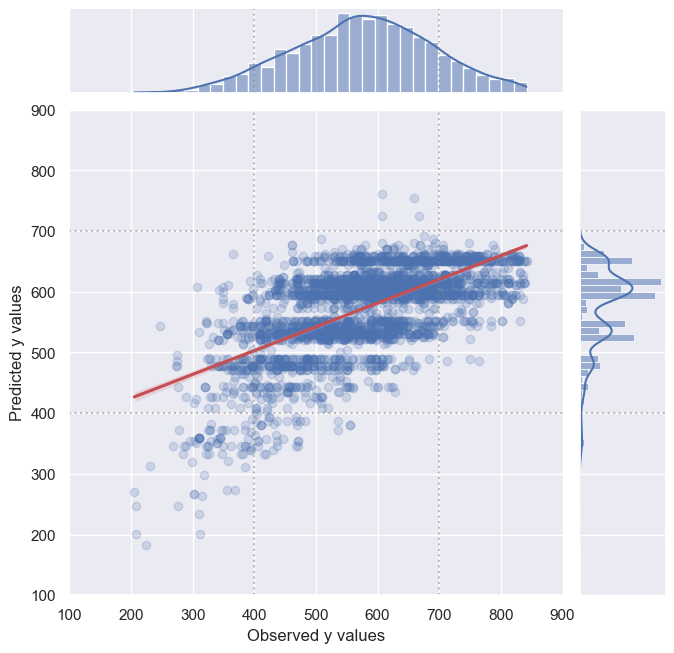

Prediction R squared: 0.3918 p-value: 0.0000
y = 0.3918x +346.4 


RESIDUALS PLOT - SORTED BY ASCENDING OBSERVED DEPENDENT VARIABLE


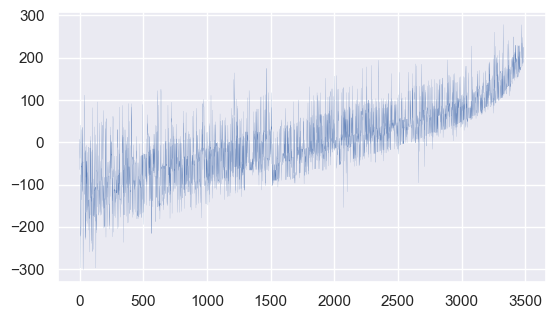

RESIDUALS NORMALITY
KstestResult(statistic=0.49868647055973103, pvalue=0.0, statistic_location=3.0083089879029785, statistic_sign=-1)
Residuals Histogram


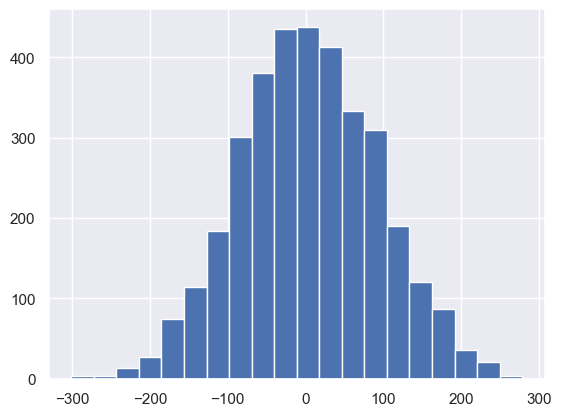

____________________________________________________________________________________ 
___________________________________________________________________________________





HC2 

MI 


Before: (2484, 22) (2484,) (825, 22) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 22) (2484,) (825, 22) (825,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 18
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     84.42
Date:                Thu, 11 Apr 2024   Prob (F-statistic):          5.55e-241
Time:                        14:28:50   Log-Likelihood:                -14699.
No. Observations:                2484   AIC:                         2.944e+04
Df Residuals:                    2465   BIC:                         2.955e+04
Df Model:                          18                                         
Covariance Type:                  HC2                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   489.3096      3.436    142.397      0.000     482.575     496.045
job_name_Applied         75.1104     11.606      6.472      0.000      52.363      97.858
job_name_Architect       81.9731     18.075      4.535      0.000      46.547     117.399
job_name_Consultant     -53.9694     17.215     -3.135      0.002     -87.710     -20.229
job_name_Product         87.0325     25.325      3.437      0.001      37.397     136.668
job_name_Machine         56.6344      7.303      7.755      0.000      42.322      70.947
job_name_Operations     -44.7755     19.172     -2.335      0.020     -82.352      -7.199
job_name_Modeler         66.3104     28.885      2.296      0.022       9.696     122.925
job_name_Engineer        54.3332      4.511     12.044      0.000      45.492      63.175
job_name_Research        37.7964      9.926      3.808      0.000      18.342      57.250
job_name_Scientist       63.0943      4.879     12.933      0.000      53.532      72.656
job_name_Manager         31.9511      8.023      3.982      0.000      16.226      47.677
salary_currency_CAD    -103.5960     35.829     -2.891      0.004    -173.819     -33.373
salary_currency_GBP    -117.6811      5.236    -22.474      0.000    -127.944    -107.418
employee_residence_BR   -59.4242     11.044     -5.381      0.000     -81.069     -37.779
employee_residence_GR   -84.0428     13.745     -6.114      0.000    -110.982     -57.103
employee_residence_LV   -85.0410     14.290     -5.951      0.000    -113.048     -57.034
remote_ratio_Remote     -17.9142      4.057     -4.415      0.000     -25.867      -9.962
company_location_BR     -59.4242     11.044     -5.381      0.000     -81.069     -37.779
company_location_GR     -84.0428     13.745     -6.114      0.000    -110.982     -57.103
company_location_IN    -288.0768     13.807    -20.864      0.000    -315.139    -261.015
company_location_LV     -85.0410     14.290     -5.951      0.000    -113.048     -57.034
==============================================================================
Omnibus:                        7.360   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.388
Skew:                           0.134   Prob(JB):                       0.0249
Kurtosis:                       2.991   Cond. No.                     4.57e+17
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The smallest eigenvalue is 1.64e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

___________________________________________________________


HC2 

SE 


Before: (7038, 24) (7038,) (2333, 24) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 24) (7038,) (2333, 24) (2333,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 21
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     203.4
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:28:51   Log-Likelihood:                -41327.
No. Observations:                7038   AIC:                         8.270e+04
Df Residuals:                    7016   BIC:                         8.285e+04
Df Model:                          21                                         
Covariance Type:                  HC2                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.339e+04   3436.528     -3.896      0.000   -2.01e+04   -6654.709
work_year                 6.8808      1.699      4.051      0.000       3.552      10.210
job_name_AI              29.5529     12.146      2.433      0.015       5.748      53.358
job_name_Applied         37.5683      5.853      6.419      0.000      26.096      49.040
job_name_Architect       81.2863      6.121     13.280      0.000      69.289      93.283
job_name_Consultant     -93.0536      7.666    -12.139      0.000    -108.078     -78.029
job_name_Lead            28.9266     14.289      2.024      0.043       0.921      56.932
job_name_Principal      109.6735     22.878      4.794      0.000      64.833     154.514
job_name_Vision          78.4071     15.747      4.979      0.000      47.543     109.272
job_name_Machine         56.1605      3.214     17.475      0.000      49.862      62.459
job_name_Engineer        65.6046      3.019     21.728      0.000      59.687      71.523
job_name_Research        36.4697      5.099      7.152      0.000      26.476      46.464
job_name_Scientist       84.7752      2.983     28.418      0.000      78.928      90.622
job_name_Manager         44.0045      6.897      6.380      0.000      30.487      57.522
salary_currency_CAD     -83.5117     16.243     -5.141      0.000    -115.348     -51.675
salary_currency_EUR    -172.2497     11.694    -14.730      0.000    -195.169    -149.330
salary_currency_GBP    -142.5242      6.782    -21.014      0.000    -155.818    -129.231
salary_currency_INR    -286.2716     23.829    -12.014      0.000    -332.976    -239.568
employee_residence_CO   -91.5565     12.268     -7.463      0.000    -115.602     -67.511
employee_residence_ZA   -47.5475     13.041     -3.646      0.000     -73.107     -21.988
company_location_BR    -276.2975     40.107     -6.889      0.000    -354.905    -197.690
company_location_CO     -91.5565     12.268     -7.463      0.000    -115.602     -67.511
company_location_ES     -83.8486     13.845     -6.056      0.000    -110.984     -56.713
company_location_ZA     -47.5475     13.041     -3.646      0.000     -73.107     -21.988
==============================================================================
Omnibus:                        8.087   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.517
Skew:                           0.045   Prob(JB):                       0.0233
Kurtosis:                       2.868   Cond. No.                     7.84e+20
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
[2] The smallest eigenvalue is 4.69e-32. This might indicate that there are
strong multicollinearity problems or th

___________________________________________________________


HC2 

EN 


Before: (742, 8) (742,) (243, 8) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 8) (742,) (243, 8) (243,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     65.28
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           5.18e-73
Time:                        14:28:51   Log-Likelihood:                -4403.0
No. Observations:                 742   AIC:                             8822.
Df Residuals:                     734   BIC:                             8859.
Df Model:                           7                                         
Covariance Type:                  HC2                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 477.5119      4.586    104.121      0.000     468.523     486.501
job_name_Applied      115.0530     38.136      3.017      0.003      40.307     189.799
job_name_Machine       43.0204     19.535      2.202      0.028       4.732      81.309
job_name_Research      71.0071     14.328      4.956      0.000      42.924      99.090
employment_type_PT    -96.1629     19.101     -5.034      0.000    -133.600     -58.726
salary_currency_EUR  -144.6179     11.046    -13.093      0.000    -166.267    -122.969
salary_currency_GBP  -132.1629      8.800    -15.018      0.000    -149.411    -114.915
remote_ratio_Remote   -34.8224      7.412     -4.698      0.000     -49.350     -20.295
==============================================================================
Omnibus:                       14.305   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.034
Skew:                           0.188   Prob(JB):                     4.46e-05
Kurtosis:                       3.712   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

___________________________________________________________


HC2 

EX 


Before: (286, 3) (286,) (87, 3) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 3) (286,) (87, 3) (87,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     9.977
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           6.50e-05
Time:                        14:28:51   Log-Likelihood:                -1725.4
No. Observations:                 286   AIC:                             3457.
Df Residuals:                     283   BIC:                             3468.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 627.8954      7.603     82.584      0.000     612.994     642.797
job_name_Director      52.3093     14.914      3.507      0.000      23.079      81.540
remote_ratio_Remote    35.0994     12.703      2.763      0.006      10.201      59.998
==============================================================================
Omnibus:                        8.953   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.591
Skew:                          -0.319   Prob(JB):                       0.0225
Kurtosis:                       2.520   Cond. No.                         4.01
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""

___________________________________________________________




,Observed,Predicted,Residual
count,3488.000000,3488.000000,3488.000000
mean,576.100189,572.089291,4.010898
std,113.938141,71.326194,88.858955
min,205.530046,183.318617,-301.051646
25%,497.601961,529.747495,-57.703040
50%,579.108975,595.352057,2.975939
75%,653.339300,617.914658,64.096782
max,841.488869,761.186051,278.214646


Scatter plot of Predicted vs Actual values


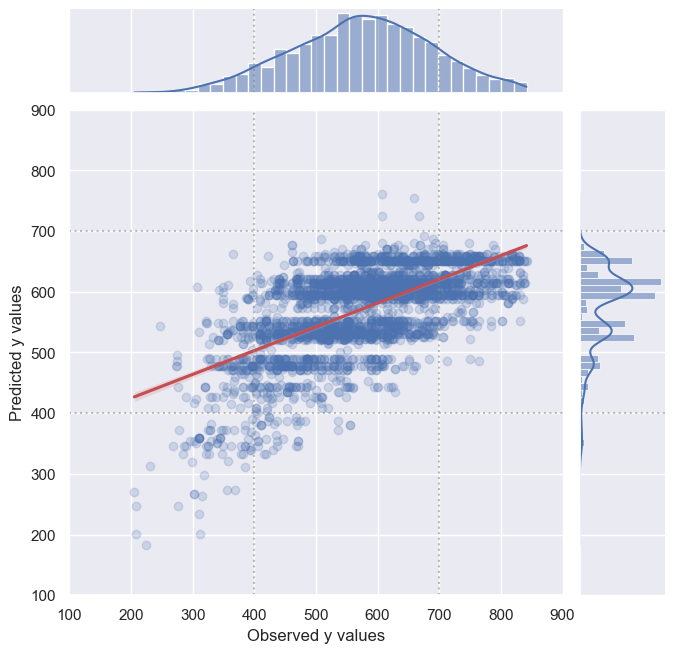

Prediction R squared: 0.3918 p-value: 0.0000
y = 0.3918x +346.4 


RESIDUALS PLOT - SORTED BY ASCENDING OBSERVED DEPENDENT VARIABLE


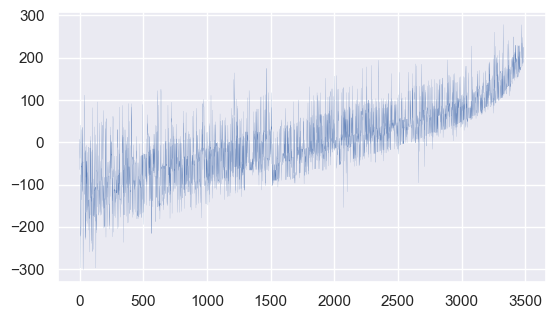

RESIDUALS NORMALITY
KstestResult(statistic=0.49868647055973103, pvalue=0.0, statistic_location=3.0083089879029785, statistic_sign=-1)
Residuals Histogram


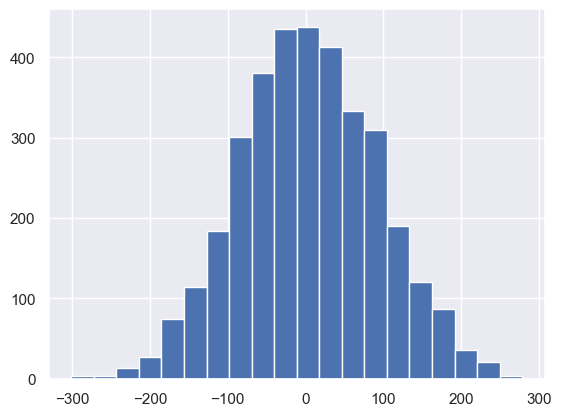

____________________________________________________________________________________ 
___________________________________________________________________________________





HC3 

MI 


Before: (2484, 22) (2484,) (825, 22) (825,)
Rows deleted: 0
Columns dropped: 0
After: (2484, 22) (2484,) (825, 22) (825,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 18
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     80.88
Date:                Thu, 11 Apr 2024   Prob (F-statistic):          1.86e-232
Time:                        14:28:52   Log-Likelihood:                -14699.
No. Observations:                2484   AIC:                         2.944e+04
Df Residuals:                    2465   BIC:                         2.955e+04
Df Model:                          18                                         
Covariance Type:                  HC3                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   489.3096      3.446    141.982      0.000     482.555     496.064
job_name_Applied         75.1104     11.747      6.394      0.000      52.087      98.134
job_name_Architect       81.9731     18.657      4.394      0.000      45.407     118.539
job_name_Consultant     -53.9694     17.906     -3.014      0.003     -89.065     -18.874
job_name_Product         87.0325     26.304      3.309      0.001      35.477     138.588
job_name_Machine         56.6344      7.330      7.727      0.000      42.269      71.000
job_name_Operations     -44.7755     19.677     -2.276      0.023     -83.342      -6.209
job_name_Modeler         66.3104     30.443      2.178      0.029       6.644     125.977
job_name_Engineer        54.3332      4.524     12.011      0.000      45.467      63.199
job_name_Research        37.7964      9.975      3.789      0.000      18.246      57.347
job_name_Scientist       63.0943      4.893     12.896      0.000      53.505      72.683
job_name_Manager         31.9511      8.068      3.960      0.000      16.137      47.765
salary_currency_CAD    -103.5960     38.427     -2.696      0.007    -178.912     -28.280
salary_currency_GBP    -117.6811      5.262    -22.365      0.000    -127.994    -107.368
employee_residence_BR   -59.4242     11.911     -4.989      0.000     -82.770     -36.078
employee_residence_GR   -84.0428     14.852     -5.659      0.000    -113.152     -54.934
employee_residence_LV   -85.0410     15.954     -5.330      0.000    -116.310     -53.772
remote_ratio_Remote     -17.9142      4.070     -4.402      0.000     -25.891      -9.937
company_location_BR     -59.4242     11.911     -4.989      0.000     -82.770     -36.078
company_location_GR     -84.0428     14.852     -5.659      0.000    -113.152     -54.934
company_location_IN    -288.0768     14.602    -19.729      0.000    -316.696    -259.458
company_location_LV     -85.0410     15.954     -5.330      0.000    -116.310     -53.772
==============================================================================
Omnibus:                        7.360   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                7.388
Skew:                           0.134   Prob(JB):                       0.0249
Kurtosis:                       2.991   Cond. No.                     4.57e+17
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is 1.64e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

___________________________________________________________


HC3 

SE 


Before: (7038, 24) (7038,) (2333, 24) (2333,)
Rows deleted: 0
Columns dropped: 0
After: (7038, 24) (7038,) (2333, 24) (2333,)


C:\Users\Captain\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 21
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     198.9
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:28:53   Log-Likelihood:                -41327.
No. Observations:                7038   AIC:                         8.270e+04
Df Residuals:                    7016   BIC:                         8.285e+04
Df Model:                          21                                         
Covariance Type:                  HC3                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.339e+04   3446.896     -3.885      0.000   -2.01e+04   -6634.389
work_year                 6.8808      1.704      4.039      0.000       3.542      10.220
job_name_AI              29.5529     12.257      2.411      0.016       5.529      53.577
job_name_Applied         37.5683      5.867      6.404      0.000      26.070      49.067
job_name_Architect       81.2863      6.140     13.240      0.000      69.253      93.320
job_name_Consultant     -93.0536      7.750    -12.007      0.000    -108.243     -77.864
job_name_Lead            28.9266     14.505      1.994      0.046       0.497      57.356
job_name_Principal      109.6735     25.099      4.370      0.000      60.481     158.866
job_name_Vision          78.4071     16.572      4.731      0.000      45.927     110.888
job_name_Machine         56.1605      3.217     17.456      0.000      49.855      62.466
job_name_Engineer        65.6046      3.023     21.699      0.000      59.679      71.530
job_name_Research        36.4697      5.109      7.139      0.000      26.457      46.482
job_name_Scientist       84.7752      2.987     28.379      0.000      78.920      90.630
job_name_Manager         44.0045      6.924      6.355      0.000      30.434      57.575
salary_currency_CAD     -83.5117     16.786     -4.975      0.000    -116.413     -50.611
salary_currency_EUR    -172.2497     11.893    -14.483      0.000    -195.560    -148.939
salary_currency_GBP    -142.5242      6.821    -20.895      0.000    -155.893    -129.156
salary_currency_INR    -286.2716     25.589    -11.187      0.000    -336.425    -236.118
employee_residence_CO   -91.5565     13.444     -6.810      0.000    -117.905     -65.208
employee_residence_ZA   -47.5475     14.248     -3.337      0.001     -75.473     -19.622
company_location_BR    -276.2975     45.438     -6.081      0.000    -365.354    -187.241
company_location_CO     -91.5565     13.444     -6.810      0.000    -117.905     -65.208
company_location_ES     -83.8486     14.089     -5.951      0.000    -111.462     -56.235
company_location_ZA     -47.5475     14.248     -3.337      0.001     -75.473     -19.622
==============================================================================
Omnibus:                        8.087   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                7.517
Skew:                           0.045   Prob(JB):                       0.0233
Kurtosis:                       2.868   Cond. No.                     7.84e+20
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The smallest eigenvalue is 4.69e-32. This might indicate that there are
strong multicollinearity problems or th

___________________________________________________________


HC3 

EN 


Before: (742, 8) (742,) (243, 8) (243,)
Rows deleted: 0
Columns dropped: 0
After: (742, 8) (742,) (243, 8) (243,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     63.32
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           3.50e-71
Time:                        14:28:53   Log-Likelihood:                -4403.0
No. Observations:                 742   AIC:                             8822.
Df Residuals:                     734   BIC:                             8859.
Df Model:                           7                                         
Covariance Type:                  HC3                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 477.5119      4.606    103.674      0.000     468.484     486.539
job_name_Applied      115.0530     40.349      2.851      0.004      35.970     194.136
job_name_Machine       43.0204     19.914      2.160      0.031       3.990      82.051
job_name_Research      71.0071     14.437      4.918      0.000      42.711      99.303
employment_type_PT    -96.1629     20.432     -4.707      0.000    -136.208     -56.118
salary_currency_EUR  -144.6179     11.236    -12.871      0.000    -166.639    -122.596
salary_currency_GBP  -132.1629      8.876    -14.891      0.000    -149.559    -114.767
remote_ratio_Remote   -34.8224      7.465     -4.664      0.000     -49.454     -20.190
==============================================================================
Omnibus:                       14.305   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.034
Skew:                           0.188   Prob(JB):                     4.46e-05
Kurtosis:                       3.712   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

___________________________________________________________


HC3 

EX 


Before: (286, 3) (286,) (87, 3) (87,)
Rows deleted: 0
Columns dropped: 0
After: (286, 3) (286,) (87, 3) (87,)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     transformed_salary   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     9.661
Date:                Thu, 11 Apr 2024   Prob (F-statistic):           8.73e-05
Time:                        14:28:53   Log-Likelihood:                -1725.4
No. Observations:                 286   AIC:                             3457.
Df Residuals:                     283   BIC:                             3468.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 627.8954      7.628     82.318      0.000     612.945     642.845
job_name_Director      52.3093     15.224      3.436      0.001      22.471      82.148
remote_ratio_Remote    35.0994     12.768      2.749      0.006      10.075      60.124
==============================================================================
Omnibus:                        8.953   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.591
Skew:                          -0.319   Prob(JB):                       0.0225
Kurtosis:                       2.520   Cond. No.                         4.01
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

___________________________________________________________




,Observed,Predicted,Residual
count,3488.000000,3488.000000,3488.000000
mean,576.100189,572.089291,4.010898
std,113.938141,71.326194,88.858955
min,205.530046,183.318617,-301.051646
25%,497.601961,529.747495,-57.703040
50%,579.108975,595.352057,2.975939
75%,653.339300,617.914658,64.096782
max,841.488869,761.186051,278.214646


Scatter plot of Predicted vs Actual values


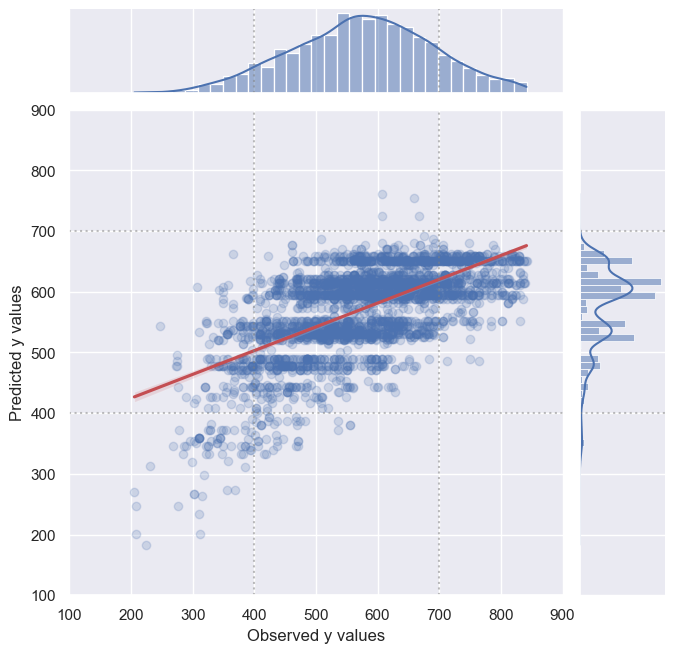

Prediction R squared: 0.3918 p-value: 0.0000
y = 0.3918x +346.4 


RESIDUALS PLOT - SORTED BY ASCENDING OBSERVED DEPENDENT VARIABLE


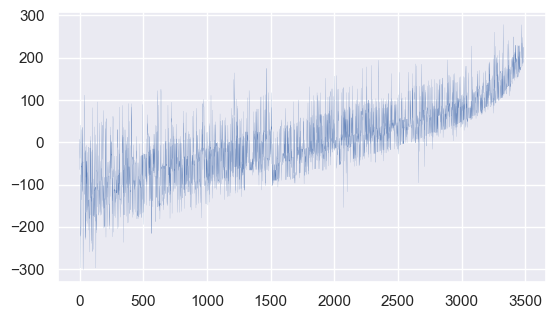

RESIDUALS NORMALITY
KstestResult(statistic=0.49868647055973103, pvalue=0.0, statistic_location=3.0083089879029785, statistic_sign=-1)
Residuals Histogram


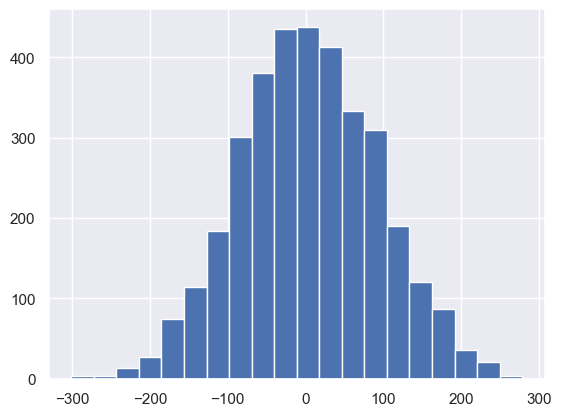

____________________________________________________________________________________ 
___________________________________________________________________________________







In [37]:
# Predictions and summary
y_pred = {}
OLS_model = {}

X_train_backup = X_train.copy()
X_test_backup = X_test.copy()
y_train_backup = y_train.copy()
y_test_backup = y_test.copy()
    
for cov_type in ['nonrobust', 'HC0', 'HC1', 'HC2', 'HC3']:
    for exp in aijobs['experience_level'].unique():
        print(cov_type, '\n')
        print(exp, '\n')
        OLS_model[exp] = model_creation(X_train[exp], X_test[exp], y_train[exp], y_test[exp], cov_type)
        y_pred[exp] = OLS_model[exp].predict(X_test[exp])
        display(OLS_model[exp].summary())
        print('___________________________________________________________\n\n')
    pred = pd.concat([y_pred['MI'], y_pred['SE'], y_pred['EN'], y_pred['EX']])
    test = pd.concat([y_test['MI'], y_test['SE'], y_test['EN'], y_test['EX']])
    create_scatter(pred, test)
    X_train = X_train_backup.copy()
    X_test = X_test_backup.copy()
    y_train = y_train_backup.copy()
    y_test = y_test_backup.copy()
    print('____________________________________________________________________________________',
          '\nNEXT HC'
          '\n____________________________________________________________________________________\n\n\n\n\n')